In [43]:
import numpy as np
import pandas as pd
import os
import random
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from keras_tuner import Hyperband
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [47]:
DATA_PATH = './data/original'
CNN_RESULTS = './results/cnn_images'

TRAIN_DIRECTORY = 'train'
VALIDATION_DIRECTORY = 'val'
TEST_DIRECTORY = 'test'

SUB_DIRECTORIES = [TRAIN_DIRECTORY, TEST_DIRECTORY, VALIDATION_DIRECTORY]
CATEGORY_DIRECTORIES = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'Healthy', 'HFMD', 'Measles', 'Melanocytic nevi', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']

In [5]:
def count_images(dir_name):
    for dataset_type in SUB_DIRECTORIES:
        total = 0
        dir_type = os.path.join(dir_name, dataset_type)
        print(f"============ {dataset_type} dataset ===========")
        for category in os.listdir(dir_type):
            category_path = os.path.join(dir_type, category)
            if not os.path.isdir(category_path):
                continue
            images = [img for img in os.listdir(category_path) if img.endswith(('jpg','jpeg'))]
            print(f"Number of images in {category_path.split('/')[-1]}: {len(images)}")
            total += len(images)
        print(f"Total image count: {total}")
        print("")

In [6]:
count_images(DATA_PATH)

============ train dataset ===========
Number of images in Benign keratosis-like lesions: 1000
Number of images in Cowpox: 792
Number of images in Healthy: 1000
Number of images in Actinic keratoses: 693
Number of images in Melanoma: 1000
Number of images in HFMD: 1000
Number of images in Melanocytic nevi: 1000
Number of images in Measles: 660
Number of images in Chickenpox: 900
Number of images in Basal cell carcinoma: 1000
Number of images in Squamous cell carcinoma: 502
Number of images in Monkeypox: 1000
Number of images in Dermatofibroma: 191
Number of images in Vascular lesions: 202
Total image count: 10940

============ test dataset ===========
Number of images in Benign keratosis-like lesions: 100
Number of images in Cowpox: 99
Number of images in Healthy: 100
Number of images in Actinic keratoses: 88
Number of images in Melanoma: 100
Number of images in HFMD: 100
Number of images in Melanocytic nevi: 100
Number of images in Measles: 83
Number of images in Chickenpox: 100
Numbe

In [32]:
def load_images_to_df(base_path, dataset_type):
    path = os.path.join(base_path, dataset_type)
    image_dir = Path(path)

    file_paths = list(image_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

    file_paths = pd.Series(file_paths, name='Path').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([file_paths, labels], axis=1)

    samples = []
    for record in image_df['Label'].unique():
        samples.append(image_df[image_df['Label']==record])
    image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

    return image_df

In [33]:
df_train = load_images_to_df(DATA_PATH, TRAIN_DIRECTORY)
df_train.head(10)

,Path,Label
0,data/original/train/Benign keratosis-like lesi...,Benign keratosis-like lesions
1,data/original/train/Healthy/HEALTHY_59_02_8.jpg,Healthy
2,data/original/train/Melanocytic nevi/ISIC_0010...,Melanocytic nevi
3,data/original/train/Healthy/HEALTHY_26_02_8.jpg,Healthy
4,data/original/train/Monkeypox/MKP_142_06_9.jpg,Monkeypox
5,data/original/train/Vascular lesions/ISIC_0027...,Vascular lesions
6,data/original/train/Melanocytic nevi/ISIC_0011...,Melanocytic nevi
7,data/original/train/Healthy/HEALTHY_58_01_ORIG...,Healthy
8,data/original/train/Cowpox/CWP_19_01_13.jpg,Cowpox
9,data/original/train/Benign keratosis-like lesi...,Benign keratosis-like lesions


In [20]:
df_val = load_images_to_df(DATA_PATH, VALIDATION_DIRECTORY)
df_val.head(10)

,Path,Label
0,data/original/val/Benign keratosis-like lesion...,Benign keratosis-like lesions
1,data/original/val/Benign keratosis-like lesion...,Benign keratosis-like lesions
2,data/original/val/Benign keratosis-like lesion...,Benign keratosis-like lesions
3,data/original/val/Benign keratosis-like lesion...,Benign keratosis-like lesions
4,data/original/val/Benign keratosis-like lesion...,Benign keratosis-like lesions
5,data/original/val/Benign keratosis-like lesion...,Benign keratosis-like lesions
6,data/original/val/Benign keratosis-like lesion...,Benign keratosis-like lesions
7,data/original/val/Benign keratosis-like lesion...,Benign keratosis-like lesions
8,data/original/val/Benign keratosis-like lesion...,Benign keratosis-like lesions
9,data/original/val/Benign keratosis-like lesion...,Benign keratosis-like lesions


In [34]:
df_test = load_images_to_df(DATA_PATH, TEST_DIRECTORY)
df_test.head(10)

,Path,Label
0,data/original/test/Actinic keratoses/ISIC_0071...,Actinic keratoses
1,data/original/test/Basal cell carcinoma/ISIC_0...,Basal cell carcinoma
2,data/original/test/Vascular lesions/ISIC_00707...,Vascular lesions
3,data/original/test/Benign keratosis-like lesio...,Benign keratosis-like lesions
4,data/original/test/Squamous cell carcinoma/ISI...,Squamous cell carcinoma
5,data/original/test/Melanoma/ISIC_0014559_downs...,Melanoma
6,data/original/test/Monkeypox/MKP_126_01_ORIGIN...,Monkeypox
7,data/original/test/Basal cell carcinoma/ISIC_0...,Basal cell carcinoma
8,data/original/test/Actinic keratoses/ISIC_0063...,Actinic keratoses
9,data/original/test/Actinic keratoses/ISIC_0072...,Actinic keratoses


In [35]:
def pie_plot_from_df(df, title):
    pie = df["Label"].value_counts()
    pie.plot(kind="pie", autopct="%1.2f%%")
    plt.ylabel("")
    plt.xlabel(title)
    plt.show()

In [36]:
def show_images_from_df(df, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8), subplot_kw={"xticks":[], "yticks":[]})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df.Path[i], -1))
        ax.set_title(df.Label[i])
    plt.tight_layout()
    plt.show()

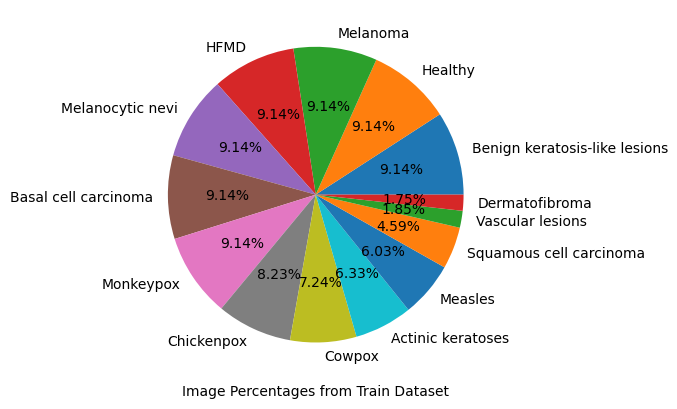

In [22]:
pie_plot_from_df(df_train, "Image Percentages from Train Dataset")

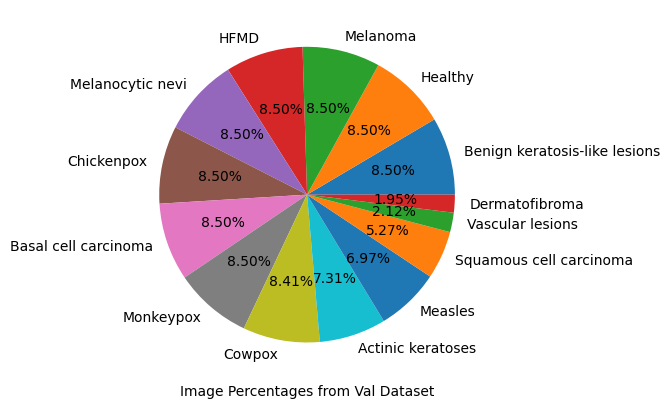

In [23]:
pie_plot_from_df(df_val, "Image Percentages from Val Dataset")

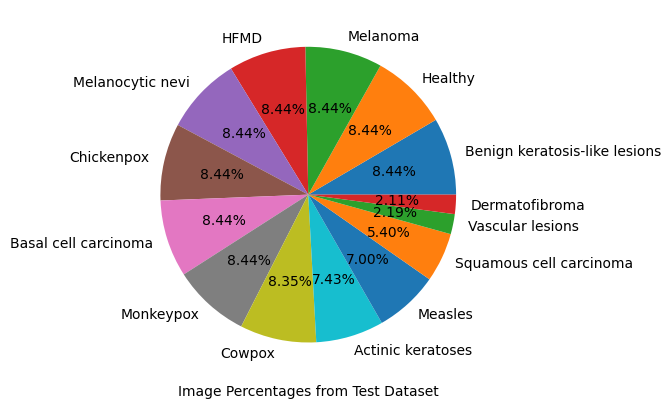

In [24]:
pie_plot_from_df(df_test, "Image Percentages from Test Dataset")

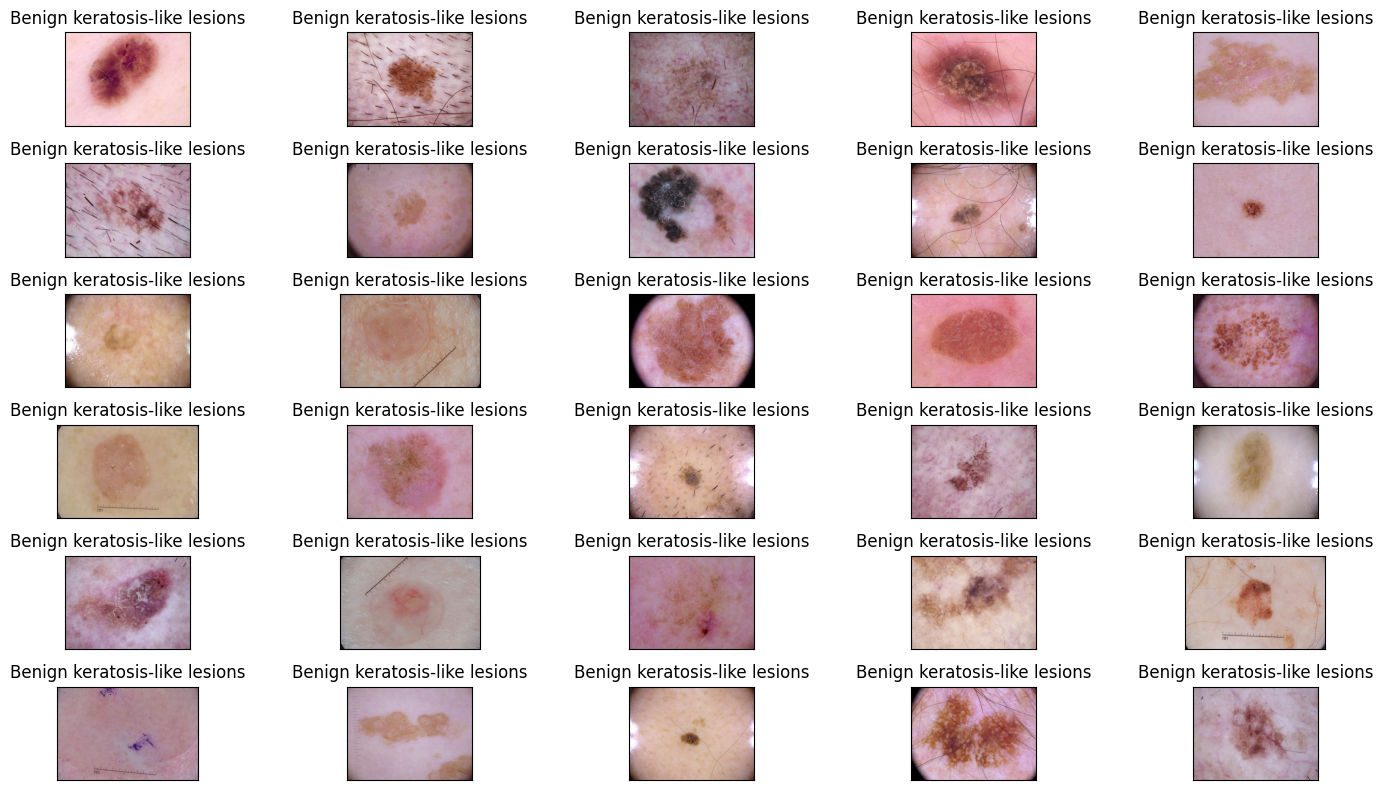

In [25]:
show_images_from_df(df_train, 6, 5)

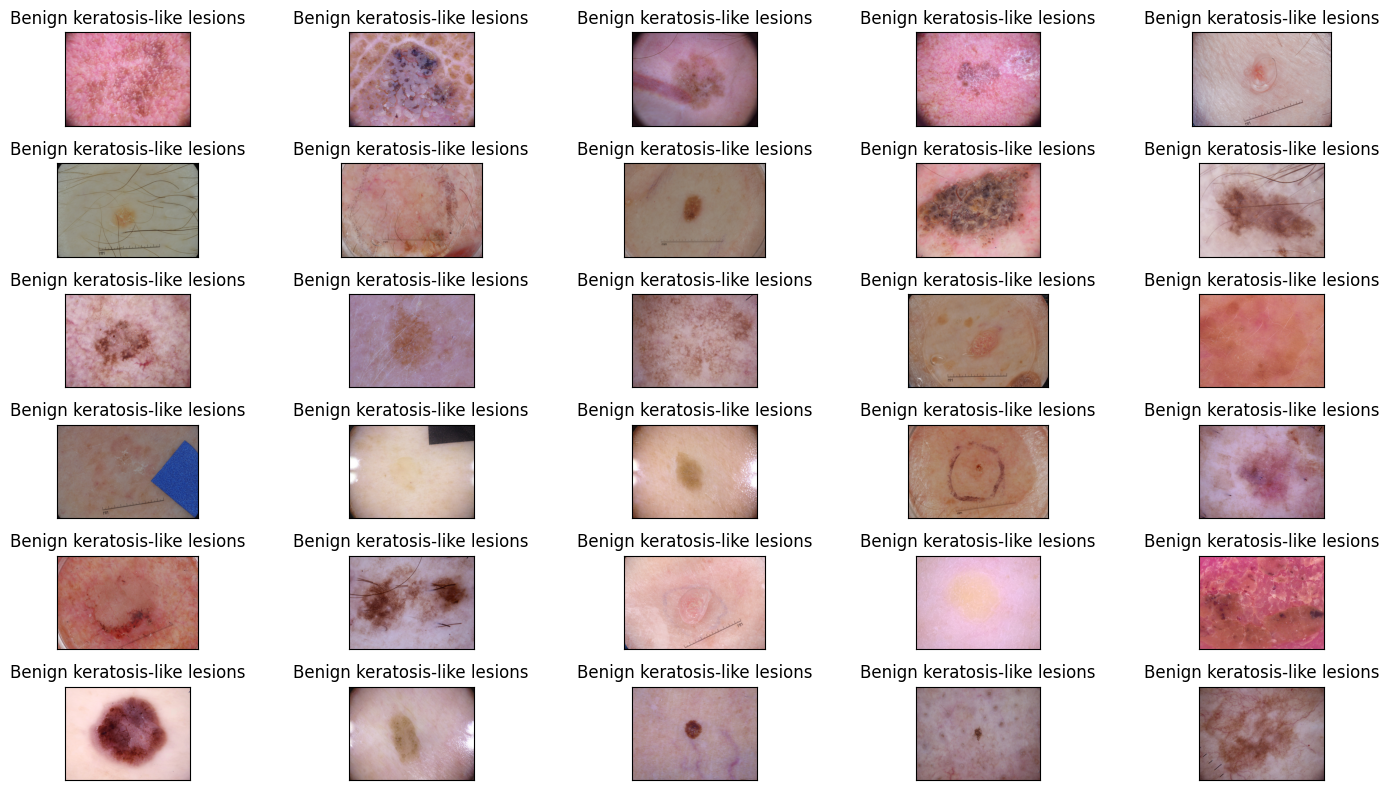

In [26]:
show_images_from_df(df_val, 6, 5)

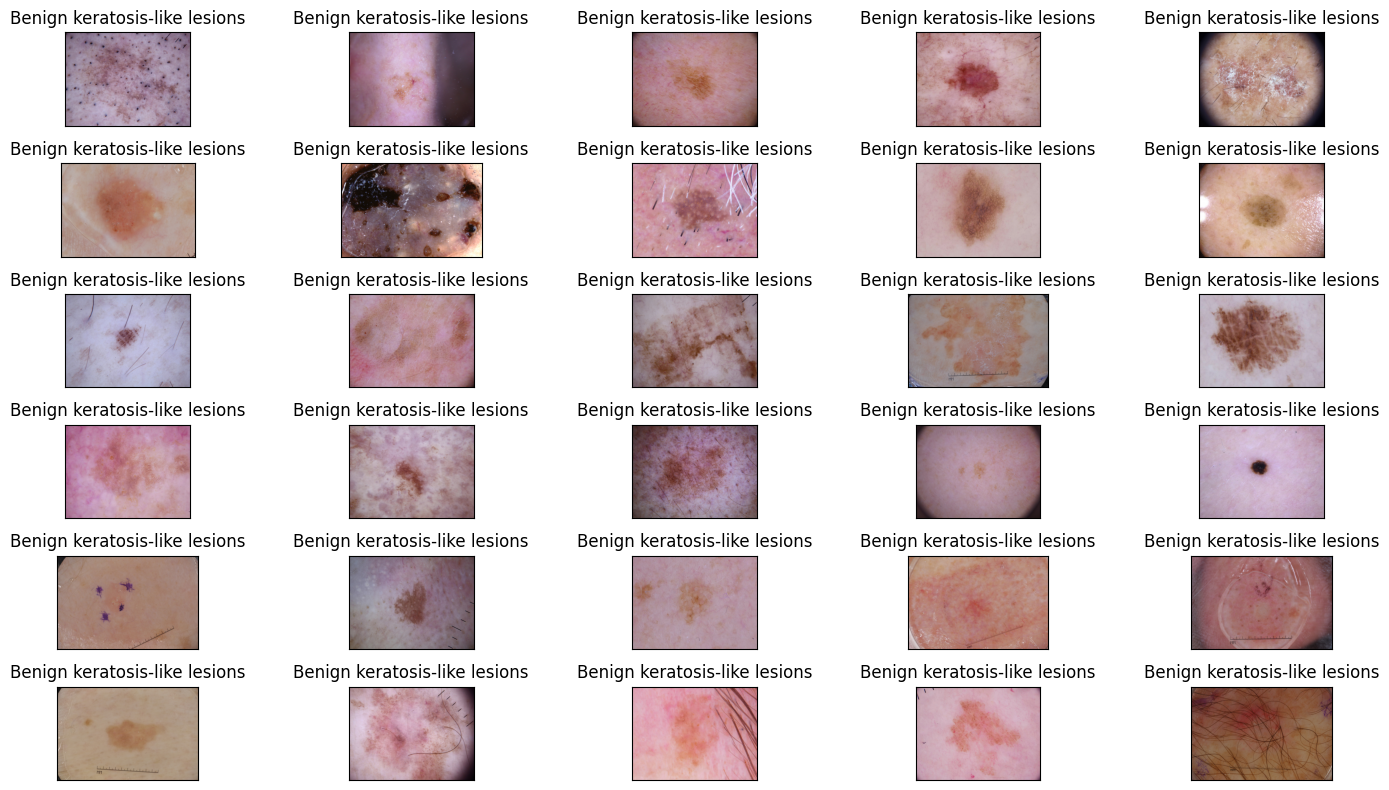

In [27]:
show_images_from_df(df_test, 6, 5)

In [40]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    channel_shift_range=0.1,
    fill_mode="nearest",
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

In [41]:
def create_dataset(generator, df, subset):
    images = generator.flow_from_dataframe(
        dataframe=df,
        x_col='Path', 
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42)
    print(f"{subset} class indices: {images.class_indices}\n")
    return images

In [42]:
train_dataset = create_dataset(train_generator, df_train, TRAIN_DIRECTORY)
val_dataset = create_dataset(val_generator, df_val, VALIDATION_DIRECTORY)
test_dataset = create_dataset(test_generator, df_test, TEST_DIRECTORY)

Found 10940 validated image filenames belonging to 14 classes.
train class indices: {'Actinic keratoses': 0, 'Basal cell carcinoma': 1, 'Benign keratosis-like lesions': 2, 'Chickenpox': 3, 'Cowpox': 4, 'Dermatofibroma': 5, 'HFMD': 6, 'Healthy': 7, 'Measles': 8, 'Melanocytic nevi': 9, 'Melanoma': 10, 'Monkeypox': 11, 'Squamous cell carcinoma': 12, 'Vascular lesions': 13}

Found 1177 validated image filenames belonging to 14 classes.
val class indices: {'Actinic keratoses': 0, 'Basal cell carcinoma': 1, 'Benign keratosis-like lesions': 2, 'Chickenpox': 3, 'Cowpox': 4, 'Dermatofibroma': 5, 'HFMD': 6, 'Healthy': 7, 'Measles': 8, 'Melanocytic nevi': 9, 'Melanoma': 10, 'Monkeypox': 11, 'Squamous cell carcinoma': 12, 'Vascular lesions': 13}

Found 1185 validated image filenames belonging to 14 classes.
test class indices: {'Actinic keratoses': 0, 'Basal cell carcinoma': 1, 'Benign keratosis-like lesions': 2, 'Chickenpox': 3, 'Cowpox': 4, 'Dermatofibroma': 5, 'HFMD': 6, 'Healthy': 7, 'Measles'

In [48]:
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

for layer in base_model.layers:
    layer.trainable = False

inputs = base_model.input

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
x - Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
outputs = Dense(len(CATEGORY_DIRECTORIES), activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

tf.keras.utils.plot_model(model, f"{CNN_RESULTS}/mobile_net_v2_model_summary.png", show_shape=True, dpi=50)

ValueError: Exception encountered when calling layer "tf.math.subtract_1" (type TFOpLambda).

Dimensions must be equal, but are 256 and 64 for '{{node tf.math.subtract_1/Sub}} = Sub[T=DT_FLOAT](Placeholder, Placeholder_1)' with input shapes: [?,256], [?,64].

Call arguments received by layer "tf.math.subtract_1" (type TFOpLambda):
  • x=tf.Tensor(shape=(None, 256), dtype=float32)
  • y=tf.Tensor(shape=(None, 64), dtype=float32)
  • name=None